# Calculating Spatial Access Metrics: Interactive Tutorial

## Introduction


---


This tutorial provides an overview of how to calculate spatial access metrics (driving distance, count, and access store) using the `spatial_access` Python package. This is an extension of CSDS' [Opioid Environment Toolkit](https://geodacenter.github.io/opioid-environment-toolkit/index.html). 

This tutorial can be adapted to calculate metrics for specific states, regions, or spatial scales (i.e. Census tract, county) for which pre-computed travel cost matrices are available. You can explore additional pre-computed travel time matrices [here](https://access.readthedocs.io/en/latest/resources.html). Note: These travel cost matrics may have some gaps, but we are presently working on refining and updating complete geographies.

This [Google Drive folder](https://drive.google.com/drive/folders/1sQtSIcIcA8WMequ_ad4yTDknKOwf-r_J?usp=sharing) includes all the data required for this tutorial: Origin centroid locations (ZIP Code Tract Area (ZCTA) centroids), Destination locations (Medications for Opioid Use Disorder (MOUD) providers), and the travel cost matrix. 

In the **Environment Setup** section below, you will find instructions on how to create a folder and copy these files to your own Google Drive to use this tutorial.

This tutorial assumes some familiarity with the Python programming language and Colab setup. You do not need any external Python installation to run this notebook. Detailed step-by-step instructions are provided below. 

Contact [Susan Paykin](mailto:spaykin@uchicago.edu) with any questions. 

## Environment Setup


---

**To run this notebook, you need to copy all content from the [Access Metrics Tutorial folder](https://drive.google.com/drive/folders/1sQtSIcIcA8WMequ_ad4yTDknKOwf-r_J) (including this notebook) on to your own Drive.** 

To do this, follow these instructions:

1. First, go to the [Access Metrics Tutorial folder](https://drive.google.com/drive/folders/1sQtSIcIcA8WMequ_ad4yTDknKOwf-r_J), press Ctrl+A on Windows or Command+A on Mac to select all the files, right-click, and then click “Make a Copy.”  Google Drive makes a copy of each file you selected, places it in your Drive, and adds “Copy of” before each item’s name. You should see a pop-up in the lower corner that says *Copied 6 files into My Drive.* 

2. Click "My Drive" on the left sidebar to go to your Drive.  You should see the 5 copied files.

3. Now, select all the file copies, right-click, and then click “Move to.”

4. Click the “New Folder” icon in the bottom-left corner. Give the new folder the name *spatial_access*, and then click the checkmark icon.

5. Click “Move Here” to move all the selected files into this directory. All your files should move into the *spatial_access* folder you just created.

6. Remove the "Copy of" text from each item by right clicking on each item and clicking "Rename". For example, *Copy of all_zip_centroids.csv* becomes *all_zip_centroids.csv*. Do this for all 6 items. 

7. You can now open the newly copied version of this Colab notebook from your *spatial_access* folder and use that version from here on out. 


In [4]:
!python --version

Python 3.7.12


### Packages overview


We will use the following packages in this tutorial:

*  `pandas`: to manipulate data
*  `geopandas`: to manipulate spatial data
*  `spatial_access`: to calculate spatial access metrics
*  `spatialindex` : dependency for spatial_access package
*  `altair` : for plotting
*  Other dependency packages for packages above
 

### Install and import packages

Let's first install the `spatialindex` package, given it is a dependency for `spatial_access` package.

In [ ]:
!apt-get install libspatialindex-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


Next, we install `spatial_access`. 

**Note:** This installation might fail to compile the first time due to some older version of dependencies. In such an instance, click ***Restart Runtime*** below the error messages in the code block, click ***Yes***, then hit the *play* button on this code block again. It will then use the updated versions of dependencies. The error message should be gone.

In [ ]:
!pip install spatial_access

Next, let's install `geopandas` and import all the required packages and modules.


In [ ]:
!pip install geopandas

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import altair as alt
from spatial_access.Models import AccessCount, AccessModel, AccessSum, AccessTime
from google.colab import drive

### Mount working directory

After installing the packages, let's mount the Google Drive. This folder will act as our working directory. 

**Make sure you have already made a copy of the *spatial_access* folder on your Drive.** See above in Environment Setup for step-by-step instructions. 

Once your copy of the *spatial_access* folder is created:
* Run the next block of code
* Go to the link created
* Follow the prompts
* *Copy + paste* the authorization code generated in the spacebox created below
* Click *return* to enter
* You should see a success message: *Mounted at content/drive*

**Note:** In case you mistakenly ran the code without creating appropriate folders, run: `from google.colab import drive
drive.flush_and_unmount()` and then re-run the code below.

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/spatial_access') # This is your spatial_acccess folder location

## Clean & Process Data


---

In this section, we will read in and shape the desired origin ZCTA centroids, destination MOUD treatment locations, and travel cost matrix to the apporpriate formats for calculating access metrics.

### Load Data


#### 1. Origin ZCTA Centroids

First, read in the ZIP Code Tract Area (ZCTA) centroids. These will be our origins the origin-destination calculations. Note that these centroids are population-weighted and are restricted to the 48 contiguous U.S. states. 


In [ ]:
origins = gpd.read_file("contiguousUSZipPopCentroids.gpkg") #, 
                     # dtype={'STATEFP':str,'COUNTYFP':str,'TRACTCE':str})
origins['GEOID'] = origins['GEOID'].astype(str).str.zfill(5)
#origins = origins.rename(columns={'LATITUDE': 'centroidLatitude', 'LONGITUDE': 'centroidLongitude'})

origins.head()

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,GEOID,Y,X,POP,state,geometry
0,99403,46.400325,-117.068225,19548,53,POINT (-117.06823 46.40033)
1,99402,46.303155,-117.059586,1875,53,POINT (-117.05959 46.30315)
2,99401,46.109281,-117.199265,273,53,POINT (-117.19927 46.10928)
3,99371,46.775955,-118.322030,311,53,POINT (-118.32203 46.77595)
4,99363,46.081181,-118.901477,216,53,POINT (-118.90148 46.08118)


####2. Destination MOUD Locations


 Next, let's read in our destinations: Medications for Opioid Use Disorder (MOUD) locations. Here, we will focus on providers of one type of MOUD called [Naltrexone](https://www.samhsa.gov/medication-assisted-treatment/medications-counseling-related-conditions/naltrexone). (You will also see reference to Vivitrol, which is a brand name of extended release Naltrexone.) 

We add an identifier column **"ID"** to each location, which will be used ahead to create Origin-Destination (O-D) pairs.

In [ ]:
dests = gpd.read_file('us-wide-moudsCleaned.gpkg')
dests = dests[dests.category == 'naltrexone/vivitrol']
dests = dests.reset_index(drop=True)
dests.head()

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,name1,name2,street1,street2,city,state,zip,zip4,category,countyGEOID,countyName,source,Longitude,Latitude,geometry
0,Four County Mental Health Center,None,1601 West 4th Street,None,Coffeyville,KS,67337,None,naltrexone/vivitrol,20125,Montgomery,SAMHSA,-95.641450,37.040293,POINT (-95.64145 37.04029)
1,Four County Mental Health Center,None,3751 West Main Street,None,Independence,KS,67301,None,naltrexone/vivitrol,20125,Montgomery,SAMHSA,-95.756636,37.225658,POINT (-95.75664 37.22566)
2,Center for Therapeutic Interventions,Bartlesville,4100 SE Adams Road,Suite E-108,Bartlesville,OK,74006,None,naltrexone/vivitrol,40147,Washington,SAMHSA,-95.930156,36.745548,POINT (-95.93016 36.74555)
3,Grand Lake Mental Health Center Inc,None,410 West Main Street,None,Barnsdall,OK,74002,None,naltrexone/vivitrol,40113,Osage,SAMHSA,-96.161862,36.561825,POINT (-96.16186 36.56182)
4,Comm Health Center of SE KS Pittsburg,Substance Use and Addiction Servs,3011 North Michigan Street,None,Pittsburg,KS,66762,None,naltrexone/vivitrol,20037,Crawford,SAMHSA,-94.696436,37.437709,POINT (-94.69644 37.43771)


**Note:** 
The precomputed travel times are calculated from centroid to centroid, and identified using their GEOIDs. Thus, we need to identify which zip codes (ZCTAs) these MOUD locations reside in and capture that GEOID. Effectively, we will snap each location to the centroid of the ZCTA it resides in. 

In the next section, we will read in ZCTA geometry and overlay the locations.

####3. ZCTA Geometry

Next, let's read in the geometry file for your area of interest. In thise case, we are looking at US-wide (national scale) MOUD treatment locations, so we will use the national ZIP Code Tract Area (ZCTA) geometry file, *contiguousUSZCTAs.gpkg*. However, you may be looking at subset of one or more states, or a few counties within one state. You can find and upload your geometry file for your area of interest (saved in a spatial data format, such as .gpkg or .shp) into the Google Drive folder. 

Depending on the size of your area, this may take a few minutes to load.  


In [ ]:
geom = gpd.read_file('contiguousUSZCTAs.gpkg')
geom = geom.rename(columns = {'GEOID10' : 'GEOID'})
geom.head()

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,ZCTA5CE10,GEOID,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,04757,04757,B5,G6350,S,334700805,3663844,+46.6676144,-068.1686355,"MULTIPOLYGON (((-68.08095 46.56746, -68.08236 ..."
1,04758,04758,B5,G6350,S,91006829,191946,+46.5592719,-067.8532254,"MULTIPOLYGON (((-67.90650 46.52526, -67.90677 ..."
2,04760,04760,B5,G6350,S,259787771,547534,+46.3393412,-067.9548745,"MULTIPOLYGON (((-67.85272 46.37207, -67.84753 ..."
3,04975,04975,B5,G6350,S,142318,0,+44.6253540,-069.5883338,"MULTIPOLYGON (((-69.58945 44.62188, -69.58938 ..."
4,04976,04976,B5,G6350,S,257908035,4722278,+44.7892800,-069.6676898,"MULTIPOLYGON (((-69.73503 44.78785, -69.73388 ..."


### Spatial Join

Given we will be using precomputed travel times from centroid to centroid, we will overlay MOUD locations over the ZCTAs, and then identify which ZCTA each location belongs in. 

First, let's make sure both spatial dataframes are projected using the same coordinate reference system (CRS).

In [ ]:
dests.geometry = dests.geometry.to_crs(epsg = 4326)
geom.geometry = geom.geometry.to_crs(epsg = 4326)

Next, let's perform the spatial join and identify the corresponding ZCTA `GEOID` (i.e., 5-digit ZIP code) for each location.

In [ ]:
destsOver = gpd.sjoin(dests, geom[['GEOID', 'geometry']], how='inner', op='intersects')
destsOver.head()

,name1,name2,street1,street2,city,state,zip,zip4,category,countyGEOID,countyName,source,Longitude,Latitude,geometry,index_right,GEOID
0,Four County Mental Health Center,None,1601 West 4th Street,None,Coffeyville,KS,67337,None,naltrexone/vivitrol,20125,Montgomery,SAMHSA,-95.641450,37.040293,POINT (-95.64145 37.04029),10819,67337
1,Four County Mental Health Center,None,3751 West Main Street,None,Independence,KS,67301,None,naltrexone/vivitrol,20125,Montgomery,SAMHSA,-95.756636,37.225658,POINT (-95.75664 37.22566),10812,67301
2,Center for Therapeutic Interventions,Bartlesville,4100 SE Adams Road,Suite E-108,Bartlesville,OK,74006,None,naltrexone/vivitrol,40147,Washington,SAMHSA,-95.930156,36.745548,POINT (-95.93016 36.74555),24089,74006
3,Grand Lake Mental Health Center Inc,None,410 West Main Street,None,Barnsdall,OK,74002,None,naltrexone/vivitrol,40113,Osage,SAMHSA,-96.161862,36.561825,POINT (-96.16186 36.56182),23582,74002
4,Comm Health Center of SE KS Pittsburg,Substance Use and Addiction Servs,3011 North Michigan Street,None,Pittsburg,KS,66762,None,naltrexone/vivitrol,20037,Crawford,SAMHSA,-94.696436,37.437709,POINT (-94.69644 37.43771),19817,66762


In [ ]:
#destsOver[destsOver.zip != destsOver.GEOID]

By running the code above (remove the hastag to un-comment), you can see that some of the addresses overlap with a different ZCTA boundary than listed in the address zip code. The zip code boundaries may have changed, or some small towns or rural areas may have different zip codes than their assigned ZCTAs. **We keep the data as is,** but this is something to understand and keep in mind for future applications. 

### Quick Plot
Next, we clean the data and plot to check accuracy.


,name1,name2,street1,street2,city,state,zip,zip4,category,countyGEOID,countyName,source,Longitude,Latitude,geometry,GEOID,ID
0,Four County Mental Health Center,None,1601 West 4th Street,None,Coffeyville,KS,67337,None,naltrexone/vivitrol,20125,Montgomery,SAMHSA,-95.641450,37.040293,POINT (-95.64145 37.04029),67337,1
1,Four County Mental Health Center,None,3751 West Main Street,None,Independence,KS,67301,None,naltrexone/vivitrol,20125,Montgomery,SAMHSA,-95.756636,37.225658,POINT (-95.75664 37.22566),67301,2
2,Center for Therapeutic Interventions,Bartlesville,4100 SE Adams Road,Suite E-108,Bartlesville,OK,74006,None,naltrexone/vivitrol,40147,Washington,SAMHSA,-95.930156,36.745548,POINT (-95.93016 36.74555),74006,3
3,Grand Lake Mental Health Center Inc,None,410 West Main Street,None,Barnsdall,OK,74002,None,naltrexone/vivitrol,40113,Osage,SAMHSA,-96.161862,36.561825,POINT (-96.16186 36.56182),74002,4
4,Comm Health Center of SE KS Pittsburg,Substance Use and Addiction Servs,3011 North Michigan Street,None,Pittsburg,KS,66762,None,naltrexone/vivitrol,20037,Crawford,SAMHSA,-94.696436,37.437709,POINT (-94.69644 37.43771),66762,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9120,CHIRON HEALING ARTS,None,"1333 King Street, Suite A",None,Bellingham,WA,98229,None,naltrexone/vivitrol,53073,Whatcom,vivitrolWeb,-122.463855,48.746084,POINT (-122.46385 48.74608),98229,9121
9121,HAGGEN PHARMACY,None,1815 MAIN ST,None,Ferndale,WA,98248,None,naltrexone/vivitrol,53073,Whatcom,vivitrolWeb,-122.580530,48.843345,POINT (-122.58053 48.84334),98248,9122
9122,SAFEWAY,None,8071 GUIDE MERIDIAN ROAD,None,Lynden,WA,98264,None,naltrexone/vivitrol,53073,Whatcom,vivitrolWeb,-122.487692,48.934238,POINT (-122.48769 48.93424),98264,9123
9123,NORTHLAND-ROLETTE HEALTH CENTER,None,401 2nd Ave.,None,Rolette,ND,58366,None,naltrexone/vivitrol,38079,Rolette,vivitrolWeb,-99.846353,48.662016,POINT (-99.84635 48.66202),58366,9124


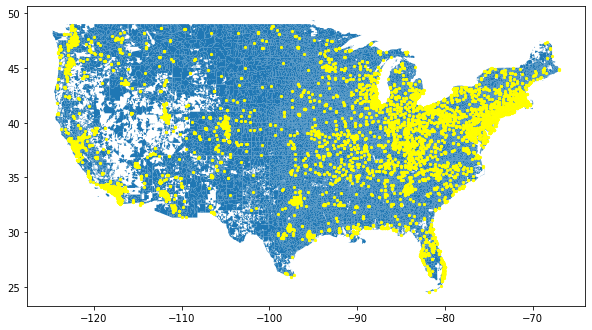

In [ ]:
# Add latitude, longitude colums
destsOver['lon'] = destsOver.geometry.apply(lambda p: p.x)
destsOver['lat'] = destsOver.geometry.apply(lambda p: p.y)

destsOver = destsOver.reset_index(drop=True)
destsOver['ID'] = destsOver.index + 1
destsOver = destsOver[~destsOver.GEOID.isna()]
destsOver = destsOver.drop(columns=['index_right'])
destsOver['GEOID'] = destsOver['GEOID'].astype(str)

# Create base layer for plotting - this should be your geometry file for your area of interest that you loaded earlier
base = geom.plot(figsize=(10,10)) # in this case, loading US-wide ZCTA geometry file

# Plot
destsOver.plot(ax=base, color='yellow', markersize = 5, figsize=(10,10))
destsOver

### Travel Cost Matrix

In this section, we will load the pre-computed ZCTA travel cost matrix for driving, and filter it for the relevant ZCTAs. 

Once the data is loaded and filtered, you will see that it is in an edge, or long, format. Unfortunately this is not the required input format for Access models defined in the `spatial_access` package. In the next section,  we will reshape this filtered dataset to the appropriate format.


In [ ]:
cost_matrix = pd.read_csv('US-ZCTA5-Travel-Time-Table.csv',dtype={'origin':str,'destination':str})
cost_matrix.head()

,origin,destination,minutes
0,01001,01001,0.00
1,01001,01002,44.46
2,01001,01003,46.47
3,01001,01005,74.97
4,01001,01007,41.48


In [ ]:
filtered_cost_matrix = cost_matrix[cost_matrix['origin'].astype(str).isin(origins.GEOID)]                                        
filtered_cost_matrix.head()

,origin,destination,minutes
0,01001,01001,0.00
1,01001,01002,44.46
2,01001,01003,46.47
3,01001,01005,74.97
4,01001,01007,41.48


### Shape Data
Next, let's merge the travel cost matrix with overlaid Naltrexone destinations (using `GEOID`), and create the required input matrix for access metric calculations.



In [ ]:
filtered_cost_matrix['destination'] = filtered_cost_matrix['destination'].astype(str)
cost_matrix_w_ids = filtered_cost_matrix.merge(destsOver[['ID', 'GEOID']], how='left', left_on='destination', right_on='GEOID')
cost_matrix_w_ids = cost_matrix_w_ids[~cost_matrix_w_ids.ID.isna()]
cost_matrix_w_ids.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,origin,destination,minutes,ID,GEOID
11,01001,01020,19.21,6141.0,01020
12,01001,01020,19.21,6142.0,01020
13,01001,01020,19.21,6143.0,01020
17,01001,01028,15.12,8570.0,01028
29,01001,01040,19.88,6107.0,01040


We have merged the destination GEOIDs with the travel cost matrix. Now, we can drop that column and use the `ID` variable to identify each location. This was the variable we had created earlier on.



In [ ]:
cost_matrix_w_ids = cost_matrix_w_ids.drop(columns=['destination','GEOID']).rename(columns={'ID':'destination'}) # drop extra columns
cost_matrix_w_ids.destination = cost_matrix_w_ids.destination.astype(int)
cost_matrix_w_ids.minutes = cost_matrix_w_ids.minutes.astype(float)
cost_matrix_w_ids.head()

,origin,minutes,destination
11,01001,19.21,6141
12,01001,19.21,6142
13,01001,19.21,6143
17,01001,15.12,8570
29,01001,19.88,6107


Next, reshape the matrix from long format to **wide format** and fill missing values with NA. Here, we use 999 to signify NA. This may take a moment to compute.

In [ ]:
m_cost_matrix = cost_matrix_w_ids.pivot_table(index='origin', columns='destination', values='minutes', fill_value=999)


In [ ]:
m_cost_matrix =  m_cost_matrix.reset_index().rename_axis(None, axis=1)
m_cost_matrix.origin = m_cost_matrix.origin.astype(str)
m_cost_matrix

,origin,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9086,9087,9088,9089,9090,9091,9092,9093,9094,9095,9096,9097,9098,9099,9100,9101,9102,9103,9104,9105,9106,9107,9108,9109,9110,9111,9112,9113,9114,9115,9116,9117,9118,9119,9120,9121,9122,9123,9124,9125
0,01001,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.00,999.00,999.00,999.00,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
1,01002,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.00,999.00,999.00,999.00,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
2,01003,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.00,999.00,999.00,999.00,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
3,01005,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.00,999.00,999.00,999.00,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
4,01007,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.00,999.00,999.00,999.00,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32159,99363,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.00,999.00,999.00,999.00,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
32160,99371,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,99.96,125.66,109.96,126.82,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0

In [ ]:
print('We started with', origins.shape[0],'origin zip codes', sep =" ")
print('We started with', dests.shape[0], 'Naltrexone destinations and were able to match',destsOver.shape[0],'locations', sep =" ")
print('Transformed cost matrix has', m_cost_matrix.shape[0], 'origins and', m_cost_matrix.shape[1]-1, 'destinations',sep = " ")

We started with 32604 origin zipcodes
We started with 9147 and were able to match 9125 locations
Transformed cost matrix has 32164 origins and 9114 destinations


As you can see above, the filtered cost matrix is missing some origin ZCTAs. The network-based cost matrix may have some gaps and not every ZCTA in the country is matched as an origin or destination. This could be due to many reasons, such as low population or lack of network.

Due to the way that these access metric calculation functions have been setup, using these matrices will throw an error. To fix this, the number of rows in origin matrix (starting points) should match the number of rows in transformed cost matrix (`m_cost_matrix`). Similarly, the number of rows in the destination matrix (Naltrexone locations) should match the number of columns in the transformed matrix. 

To address this, we can either remove the unmatched origin/destination rows from the input data, or we can add extra rows/columns in the transformed matrix and fill it with NAs.

**We will choose the latter and pad the transformed matrix with additional rows corresponding to the unmatched origin GEOIDs.**

In [ ]:
originsNotMatched = origins[~(origins.GEOID.isin(m_cost_matrix.origin))]
fillRows = pd.DataFrame(index = originsNotMatched.GEOID, columns = m_cost_matrix.columns[1:m_cost_matrix.shape[1]]).fillna(999)
fillRows = fillRows.reset_index().rename(columns={'GEOID':'origin'})
fillRows

m_cost_matrix = m_cost_matrix.append(fillRows)

Similarly if there were any missing destinations, we could've created fillColumns.

In [ ]:
destsNotMatched = destsOver[~(destsOver.ID.isin(m_cost_matrix.columns))]
fillColumns = pd.DataFrame(index = m_cost_matrix.index , columns = destsNotMatched.ID).fillna(999)
m_cost_matrix = pd.concat([m_cost_matrix,fillColumns],axis=1)
m_cost_matrix

,origin,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9097,9098,9099,9100,9101,9102,9103,9104,9105,9106,9107,9108,9109,9110,9111,9112,9113,9114,9115,9116,9117,9118,9119,9120,9121,9122,9123,9124,9125,4002,4003,4004,4005,4015,4016,4017,4024,4025,8290,8293
0,01001,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999,999,999,999,999,999,999
1,01002,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999,999,999,999,999,999,999
2,01003,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999,999,999,999,999,999,999
3,01005,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999,999,999,999,999,999,999
4,01007,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999,999,999,999,999,999,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,36769,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999,999,999,999,999,999,999
436,36728,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999,999,999,999,999,999,999
437,36723,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,

### Save Processed Data
Given it takes a bit of effort to generate these matrices, we save these intermediate files for future use. This may take a few minutes to generate and save to your *spatial_access* Drive folder. 

In [ ]:
destsOver.to_csv('intermediateDestinations.csv', index = False)
origins.to_csv('intermediateOrigins.csv', index = False)
m_cost_matrix.to_csv('transformed_matrix.csv', index = False)

## Calculate Access Metrics 


---


We can now use the processed travel cost matrices to calculate three network-based access metrics:

- Driving time to nearest resource
- Count of resources within a particular driving time

As mentioned before, the package `spatial_access` has corresponding two classes for these metrics:
- AccessTime
- AccessCount


**In the next few sections, we will:**

1. Define the access metric by providing the appropriate arguments
2. Calculate the metric
4. Save the result as a .csv or .tmx file

### Setup variables



#### Intialize models 

The standard variables required for all models are:
- Network Type : `network_type`
  - Only relevant when transit matrix is not provided but still required.
- Source File : `sources_filename`
  - Unique index identifier (ID) (integer or real): initialized using `source_column_names`
  - Latitude and longitude coordinates (real): initialized using `source_column_names`
- Destination File : `destinations_filename`
  - Unique index identifier (ID) (integer or real):  initialized using `dest_column_names`
  - Latitude and longitude coordinates (real):  initialized using `dest_column_names`
- Category for each type of facility:  initialized using `dest_column_names`                   
- Transit Matrix: `transit_matrix_filename`
    - Only use a pre-computed transit matrix (such as the matrix provided this in this tutorial)
- Decay function (only for AccessModel, not used in this script) : `decay_function`
  - Options are 'linear', 'root', or 'logit', and default is 'linear'.

In [ ]:
source_col_names = {'idx':'GEOID',
                    'population': 'skip',
                    'lon': 'X',
                    'lat': 'Y'}
dest_col_names   = {'idx':'ID',
                    'category': 'category',
                    'capacity': 'skip',
                    'lon': 'Longitude',
                    'lat': 'Latitude'}

In [ ]:
accessT = AccessTime(network_type = 'drive',
                     transit_matrix_filename = 'transformed_matrix.csv',
                     sources_filename = 'intermediateOrigins.csv',
                     destinations_filename = 'intermediateDestinations.csv',
                     source_column_names = source_col_names,
                     dest_column_names = dest_col_names)               

Sometimes the AccessTime model might fail to compile due to formatting issue with a .csv file. We recommend initializing the model with the .csv (code above) but then saving the transit matrix file as a .tmx using `accessT.tranit_matrix.write_tmx( )` as shown in the code below. Then, we reintialize the model using this new .tmx file. 

In [ ]:
accessT.transit_matrix.write_tmx('cost_matrix.tmx')
accessT = AccessTime(network_type = 'drive',
                     transit_matrix_filename = 'cost_matrix.tmx',
                     sources_filename = 'intermediateOrigins.csv',
                     destinations_filename = 'intermediateDestinations.csv',
                     source_column_names = source_col_names,
                     dest_column_names = dest_col_names)                

INFO:spatial_access.p2p:Wrote to cost_matrix.tmx in 6.91 seconds


Next, we'll initlialize the AccessCount model.

In [ ]:
accessC = AccessCount(network_type = 'drive',
                     transit_matrix_filename = 'cost_matrix.tmx',
                     sources_filename = 'intermediateOrigins.csv',
                     destinations_filename = 'intermediateDestinations.csv',
                     source_column_names = source_col_names,
                     dest_column_names = dest_col_names)               

### Calculate metrics

After initializing the models, we can now calculate the metrics using `modelname.calculate( )`. 

In [ ]:
ttn = accessT.calculate()
ttn = ttn.reset_index()

For AccessCount, variable `upper_threshold` provides the driving time area. Here, we use the threshold of 30 to indicate within 30 minutes of driving time. 

In [ ]:
nCount = accessC.calculate(upper_threshold = 30)
nCount = nCount.reset_index()
accessNalViv = ttn.merge(nCount)

#### Save final data

We can now write these access metrics to a csv file.

In [ ]:
accessNalViv.drop(['time_to_nearest_all_categories','count_in_range_all_categories'], axis=1, inplace=True)
accessNalViv = accessNalViv.rename(columns= {'index':'ZCTA'})
accessNalViv

In [ ]:
accessNalViv.to_csv('accesstoNaltrexone.csv', index = False)